<a href="https://colab.research.google.com/github/hukim1112/one-day-LLM-FT/blob/main/PEFT_LoRA_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets evaluate transformers[sentencepiece] transformers[torch]
!pip install pip install accelerate -U

대규모 사전 훈련된 모델의 파인 튜닝은 그 규모 때문에 종종 비용이 많이 듭니다. 파라미터 효율적 파인 튜닝(PEFT) 방법은 모델의 모든 파라미터가 아닌 소수의 (추가) 모델 파라미터만을 파인 튜닝함으로써 대규모 사전 훈련된 모델을 다양한 다운스트림 애플리케이션에 효율적으로 적용할 수 있게 해줍니다. 이는 계산 및 저장 비용을 크게 줄입니다. 최근의 최신 PEFT 기술은 완전히 파인 튜닝된 모델과 비교할 수 있는 성능을 달성합니다.


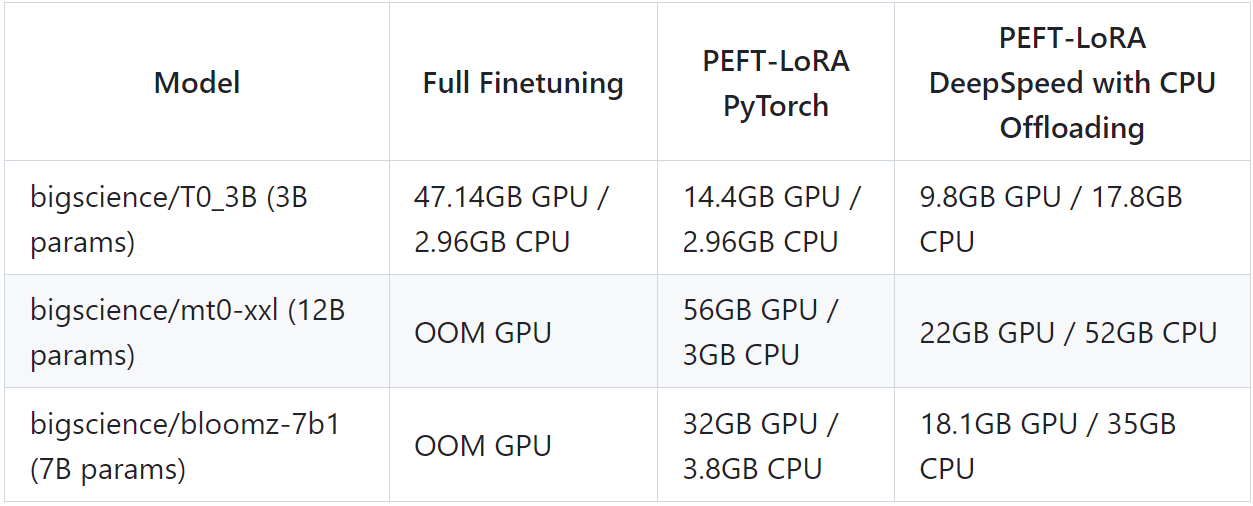








LoRA를 사용하면 80GB GPU에서 메모리 부족으로 실행할 수 없었던 12B 파라미터 모델을 완전히 미세 조정(finetune)할 수 있으며, 3B 파라미터 모델 역시 편하게  학습할 수 있습니다. 3B 파라미터 모델의 성능을 살펴보면 GPU 메모리 사용량을 줄이면서도 완전히 미세 조정된 모델과 비슷한 성능을 보여줍니다.

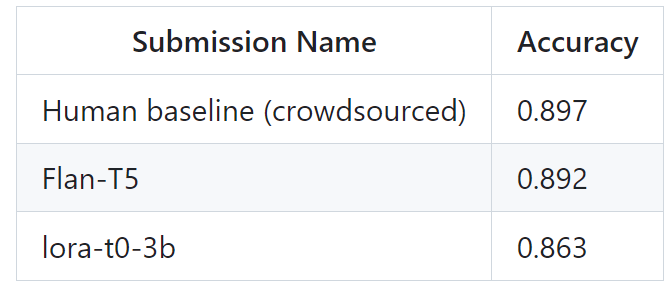

PEFT는 Transformers와 통합되어 모델 훈련 및 추론을 쉽게 하고, Diffusers를 통해 다양한 어댑터를 편리하게 관리하며, 정말 큰 모델에 대한 분산 훈련 및 추론을 위해 Accelerate와 통합되어 있습니다.

In [ ]:
!pip install peft

PEFT 방법으로 모델을 학습시키기 위해 기본 모델과 PEFT 설정을 get_peft_model로 래핑하세요. 아래 bigscience/mt0-large 모델의 경우, 파라미터의 단 0.19%만 학습시키고 있습니다.

LoRA는 훈련 가능한 매개변수의 수를 줄이는 저랭크 분해 방법으로, 대형 모델의 파인 튜닝 속도를 높이고 메모리 사용을 줄입니다. PEFT에서 LoRA를 사용하는 것은 LoraConfig를 설정하고 이를 get_peft_model()로 래핑하여 훈련 가능한 PeftModel을 생성하는 방식으로 아주 간단합니다.

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
model_name_or_path = "bigscience/mt0-large"
tokenizer_name_or_path = "bigscience/mt0-large"

peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

To load a PEFT model for inference:

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
import torch

model = AutoPeftModelForCausalLM.from_pretrained("ybelkada/opt-350m-lora").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
#"Preheat the oven to 350 degrees and place the cookie dough in the center of the oven. In a large bowl, combine the flour, baking powder, baking soda, salt, and cinnamon. In a separate bowl, combine the egg yolks, sugar, and vanilla."


In [ ]:
model.eval()
inputs = tokenizer("Preheat the oven to 350 degrees and place the cookie dough", return_tensors="pt")

outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=50)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

입력 : 오븐을 350도로 예열하고 쿠키 반죽을 놓습니다.


출력 : 오븐을 350도로 예열하고 쿠키 반죽을 오븐 가운데에 놓습니다. 큰 그릇에 밀가루, 베이킹 파우더, 베이킹 소다, 소금, 그리고 시나몬을 섞어주세요. 별도의 그릇에 노른자, 설탕, 그리고 바닐라를 섞어주세요.

### 새로운 어댑터 추가하기

peft.PeftModel.add_adapter 를 사용해서 기존 어댑터가 있는 모델에 새로운 어댑터를 추가할 수 있습니다. 단, 새로운 어댑터는 현재 어댑터와 같은 타입이어야 합니다. 예를 들어서, 모델에 이미 LoRA 어댑터가 붙어 있다면:

기존의 LoRA 어댑터 위에 또 다른 LoRA 어댑터를 추가할 수 있지만,
다른 타입의 어댑터 (예를 들어, Prefix Tuning)는 추가할 수 없습니다.

In [ ]:
from transformers import AutoModelForCausalLM, OPTForCausalLM, AutoTokenizer
from peft import LoraConfig

model_id = "facebook/opt-350m"
model = AutoModelForCausalLM.from_pretrained(model_id)

lora_config = LoraConfig(
    target_modules=["q_proj", "k_proj"],
    init_lora_weights=False
)

model.add_adapter(lora_config, adapter_name="adapter_1")

### 어댑터 활성화 및 비활성화

모델에 어댑터를 추가했다면, 어댑터 모듈을 활성화하거나 비활성화할 수 있습니다. 어댑터 모듈을 활성화하려면:

In [ ]:
from transformers import AutoModelForCausalLM, OPTForCausalLM, AutoTokenizer
from peft import PeftConfig

model_id = "facebook/opt-350m"
adapter_model_id = "ybelkada/opt-350m-lora"
tokenizer = AutoTokenizer.from_pretrained(model_id)
text = "Hello"
inputs = tokenizer(text, return_tensors="pt")

model = AutoModelForCausalLM.from_pretrained(model_id)
peft_config = PeftConfig.from_pretrained(adapter_model_id)

# to initiate with random weights
peft_config.init_lora_weights = False

model.add_adapter(peft_config)
model.enable_adapters()
output = model.generate(**inputs)

어댑터를 비활성화할 수도 있습니다.

In [ ]:
model.disable_adapters()
output = model.generate(**inputs)

In [ ]:
output

### PEFT 어댑터에 추가 학습 가능 레이어 추가하기

어댑터가 부착된 모델에서 추가적인 학습 가능한 레이어를 미세조정 (fine-tune)할 수 있습니다. PEFT 설정의 modules_to_save에 추가할 모듈들을 지정하면 됩니다. 예를 들어, LoRA 어댑터가 있는 모델에서 lm_head도 같이 미세조정을 하려면:

In [ ]:
from transformers import AutoModelForCausalLM, OPTForCausalLM, AutoTokenizer
from peft import LoraConfig

model_id = "facebook/opt-350m"
model = AutoModelForCausalLM.from_pretrained(model_id)

lora_config = LoraConfig(
    target_modules=["q_proj", "k_proj"],
    modules_to_save=["lm_head"],
)

model.add_adapter(lora_config)

- lm_head : 언어 모델의 최종 출력 레이어입니다. 다음 단어를 예측하는 데 사용됩니다.
- 기존의 facebook/opt-350m 모델을 로드하고, LoRA 어댑터를 추가하고 있습니다. 이때 modules_to_save 설정을 통해 미세조정 과정에서 lm_head 모듈도 업데이트되도록 합니다.
- 모델의 lm_head 모듈(즉, 언어 모델의 출력 계층)이 모델 저장 파일에 포함되어 저장됩니다.

##### target_modules

target_modules는 LoRA가 적용될 모델 내의 구체적인 부분(모듈)을 지정합니다. 이 매개변수는 모델의 어떤 부분에 저차원의 파라미터 수정을 적용할지를 결정하는 역할을 합니다. 즉, 이 필드에 지정된 모듈들은 모델 학습 과정에서 특별히 LoRA 메커니즘에 의해 파라미터가 조정됩니다. 예를 들어, 트랜스포머 모델의 특정 어텐션 모듈이나 피드포워드 네트워크를 대상으로 할 수 있습니다.

##### modules_to_save

modules_to_save는 학습 후 모델을 저장할 때 어떤 모듈들을 저장할지를 지정하는 매개변수입니다. LoRA를 적용할 때, 모델의 기존 파라미터는 대부분 변경되지 않으며, 주로 추가된 LoRA 파라미터들이 수정됩니다. 따라서, 전체 모델을 저장하는 대신에 변경된 부분만을 선택적으로 저장할 수 있습니다. 이는 저장 공간을 효율적으로 사용하고, 필요한 부분만을 빠르게 로드할 수 있는 장점을 제공합니다.

### [LoRA quick tour](https://huggingface.co/docs/peft/v0.10.0/en/quicktour#save-model) : 공식 홈페이지 참고자료

## Fine-tuning a model with the Trainer API or Keras

[glue 데이터셋](https://huggingface.co/datasets/nyu-mll/glue)의 mrpc 데이터셋을 활용해 학습해봅시다!

GLUE (General Language Understanding Evaluation) 벤치마크는 여러 다른 NLP 작업을 포함한 데이터셋 모음으로, 이 중 mrpc는 문장 쌍이 서로 의미상으로 동일한지를 판단하는 작업

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [ ]:
print(model)

In [ ]:
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType

In [ ]:
dir(TaskType) #LoRA에서 학습 대상 테스크입니다.

In [ ]:
config = LoraConfig(
    r=64, lora_alpha=128, lora_dropout=0.0,
    target_modules=["query", "key", 'value'], task_type=TaskType.TOKEN_CLS
)
model = get_peft_model(model, config)
print(model.print_trainable_parameters())
print(model)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()